In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, BatchNormalization,Activation,MaxPooling2D,RandomFlip
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
import keras.regularizers as regularizers
from keras.optimizers import SGD
import tensorflow as tf 
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import os
from matplotlib import image
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!gdown 1C92L4VqLNAxC1MhvlYkrC0wgXEsq2z51

Downloading...
From: https://drive.google.com/uc?id=1C92L4VqLNAxC1MhvlYkrC0wgXEsq2z51
To: /content/fer2013.zip
100% 63.3M/63.3M [00:01<00:00, 58.4MB/s]


In [5]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [6]:
train_dir = "./train/" # Directory containing the training data
test_dir = "./test/"  # Directory containing the validation data

In [7]:
import os
import pandas as pd
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

        sad  happy  angry  fear  disgust  surprise  neutral
train  4830   7215   3995  4097      436      3171     4965
       sad  happy  angry  fear  disgust  surprise  neutral
test  1247   1774    958  1024      111       831     1233


In [8]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

In [22]:
#get train, val and test datasets
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        # validation_split = 0.2,  
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=10,
        preprocessing_function=get_random_eraser(v_l=0, v_h=1,r_1=1,r_2=1,s_l=0.1,s_h=0.1)
        )

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.5
                                  )

In [23]:
BATCH_SIZE = 64
IMG_SIZE = 48
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Directory containing the training data
    target_size = (IMG_SIZE, IMG_SIZE),          # Resizes all images to 48x48 pixels
    batch_size = BATCH_SIZE,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    # subset = "training"  ,            # Uses the training subset of the data
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (IMG_SIZE, IMG_SIZE),          # Resizes all images to 48x48 pixels
    batch_size = BATCH_SIZE,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation",           # Uses the training subset of the data
    shuffle=True
    )
test_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (IMG_SIZE, IMG_SIZE),          # Resizes all images to 48x48 pixels
    batch_size = BATCH_SIZE,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "training",           # Uses the training subset of the data
    shuffle=True
    )

Found 28709 images belonging to 7 classes.
Found 3587 images belonging to 7 classes.
Found 3591 images belonging to 7 classes.


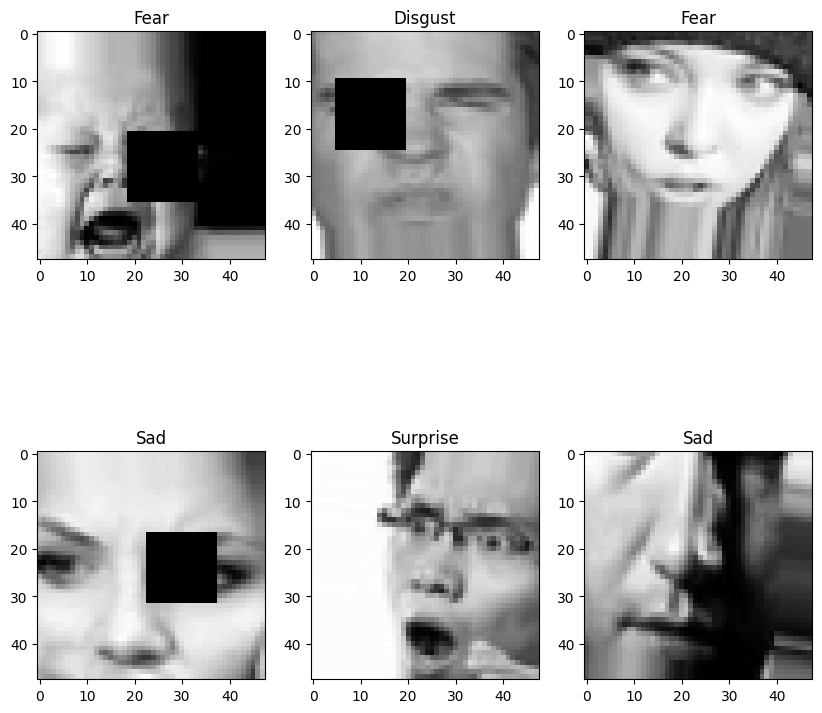

In [25]:
import random
import matplotlib.pyplot as plt
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
img , label = train_generator.__next__()
subPlot =1
plt.figure(figsize=(10,10))
for j in range(1,7):
    i = random.randint(0,(img.shape[0]-1))
    image = img[i]
    labl = class_labels[label[i].argmax()]
    plt.subplot(2,3,subPlot)
    subPlot+=1
    plt.imshow(image[:,:,0], cmap="gray")
    plt.title(labl)
plt.show()

In [26]:
model = Sequential()

model.add(Conv2D(input_shape=(48,48,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(7, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer= Adam(learning_rate=0.001,decay = 0.00001), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_33 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_28 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_34 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_29 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 64)      

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import shutil

# shutil.rmtree('./logs')
checkpoint_callback = ModelCheckpoint(
    filepath='./drive/MyDrive/MyModel.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1,
)

csv=tf.keras.callbacks.CSVLogger('./drive/MyDrive/MyModel.csv', separator=",", append=True)

lrd = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 5,
    verbose = 1,
    factor = 0.5,
    min_lr = 0.00001)

es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    patience=20)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_callback,lrd,tb_callback,csv]
)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 0.6548 - accuracy: 0.7571
Epoch 1: val_accuracy improved from -inf to 0.70282, saving model to ./drive/MyDrive/MyModel.h5
449/449 [==============================] - 43s 96ms/step - loss: 0.6548 - accuracy: 0.7571 - val_loss: 0.8612 - val_accuracy: 0.7028 - lr: 2.5000e-04
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.7599
Epoch 2: val_accuracy did not improve from 0.70282
449/449 [==============================] - 39s 86ms/step - loss: 0.6516 - accuracy: 0.7599 - val_loss: 0.8783 - val_accuracy: 0.7006 - lr: 2.5000e-04
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 0.6451 - accuracy: 0.7643
Epoch 3: val_accuracy did not improve from 0.70282
449/449 [==============================] - 39s 87ms/step - loss: 0.6451 - accuracy: 0.7643 - val_loss: 0.8779 - val_accuracy: 0.7020 - lr: 2.5000e-04
Epoch 4/50
449/449 [==============================] - ETA: 0s - 

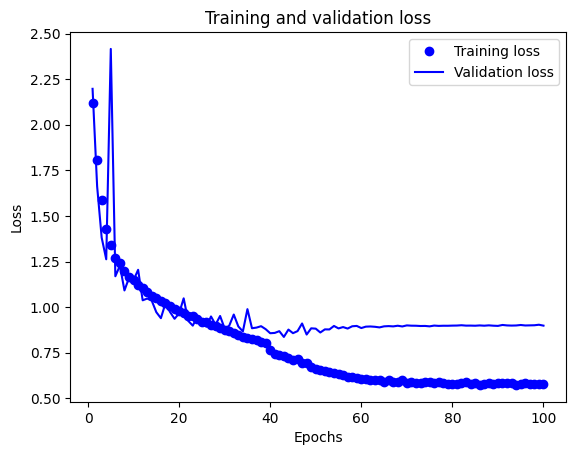

In [32]:
import matplotlib.pyplot as plt

# Plot the train and validation loss
history = pd.read_csv('./drive/MyDrive/MyModel.csv',sep=',')
train_loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

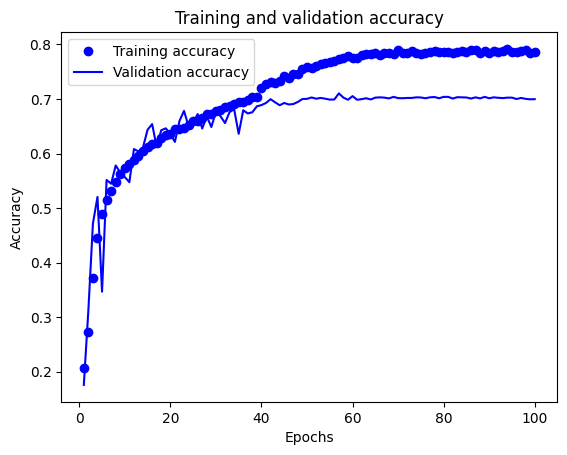

In [33]:
# Plot the train and validation accuracy
train_acc = history['accuracy']
val_acc = history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

57/57 [==============================] - 2s 26ms/step - loss: 0.9796 - accuracy: 0.6917
final train accuracy = 81.78 , validation accuracy = 69.17
